In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random

In [2]:
df = pd.read_csv('../ML Assignment/DATA/Dataset_FE2.csv')
df['diagnosis'] = df['diagnosis'].astype('category')

In [3]:
randlist=[1223, 91, 760, 1096, 670, 715, 373, 69, 538, 455]

In [4]:
train_array = [1]*10
test_array = [1]*10
X_train= [1]*10
X_tr= [1]*10
X_test= [1]*10
y_train= [1]*10
y_test = [1]*10
for i in range(10):
    train_array[i] = df.sample(frac=0.67, random_state = randlist[i])
    test_array[i] = df.drop(train_array[i].index)
    trainData_Split = train_array[i].to_numpy()
    testData_Split = test_array[i].to_numpy()
    n_samples,n_features = trainData_Split.shape
    n_features -= 1
    X_train[i] = trainData_Split[:,1:]
    y_train[i] = trainData_Split[:,0]
    X_test[i] = testData_Split[:,1:]
    y_test[i] = testData_Split[:,0]

In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [6]:
flda = LDA(n_components=1)
df=[1]*10
df0=[1]*10
df1=[1]*10
for i in range(10):
    X_train[i] = flda.fit_transform(X_train[i], y_train[i])
    X_test[i] = flda.transform(X_test[i])
    X_tr[i]=X_train[i]
    X_train[i] = pd.DataFrame(X_train[i])
    
    X_train[i]['diagnosis'] = y_train[i]
    df[i] = X_train[i].rename(columns = {0: 'feature'})
    df[i]['diagnosis'] = df[i]['diagnosis'].astype('int')
    df0[i] = df[i][df[i]['diagnosis']==0]
    df1[i] = df[i][df[i]['diagnosis'] == 1]

In [7]:
def calculate_prior(df,Y):
    classes = sorted(df[Y].unique())
    prior = []
    for i in classes:
        prior.append(len(df[df[Y] == i])/len(df))
    return prior

In [8]:
def calculate_likelihood(df, feature_name, feature_value, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean,std = df[feature_name].mean(), df[feature_name].std()
    p_x_given_y = (1/(np.sqrt(2*np.pi)*std))*np.exp(-((feature_value-mean)**2/(2 * std**2)))
    return p_x_given_y

In [9]:
def fit_normal_dist(x0, x1):
    threshold = 0
    
    X_transformed0 = x0
    X_transformed1 = x1

    mean_transformed0 = X_transformed0.mean(axis=0)
    mean_transformed1 = X_transformed1.mean(axis=0)

    variation_transformed0 = np.var(X_transformed0)
    variation_transformed1 = np.var(X_transformed1)

    a = 0.5 * ((1/variation_transformed0) - (1/variation_transformed1))
    b = 2 * ((mean_transformed1/variation_transformed1) - (mean_transformed0/variation_transformed0))
    c = (((mean_transformed0 ** 2) / variation_transformed0) - ((mean_transformed1 ** 2) / variation_transformed1)) + np.log(variation_transformed0 / variation_transformed1)
        
    D = np.sqrt((b ** 2) - (4 * a * c))

    root1 = ((-b) + D) / (2 * a)
    root2 = ((-b) - D) / (2 * a) 

    if((root1 > mean_transformed1 and root1 < mean_transformed0) or (root1 > mean_transformed0 and root1 < mean_transformed1)):
        threshold = root1
    elif((root2 > mean_transformed1 and root2 < mean_transformed0) or (root2 > mean_transformed0 and root2 < mean_transformed1)):
        threshold = root2

    return threshold


In [10]:
def GaussianNB(df, X, Y):
    
    
    features = list(df.columns)[:-1]
    
    prior = calculate_prior(df, Y)
    
    Y_pred = []

    X_0 =[]
    X_1=[]
    Xi = []
    Yi=[]
    Yj=[]
    
    for x in X:
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            likelihood[j] *= calculate_likelihood(df, features[0], x, Y, labels[j])
                
        posterior = [1]*len(labels)
        for j in range(len(labels)):
            posterior[j] = likelihood[j]*prior[j]
        Y_pred.append(np.argmax(posterior))
        
        if posterior[0] > posterior[1]:
            X_0.append(x)
#             Y_0.append(np.amax(posterior))
        if posterior[0] <= posterior[1]:
            X_1.append(x)
#             Y_1.append(np.amax(posterior))
            
        X_h = np.array(X_0)
        X_t = np.array(X_1)

        Xi.append(x)
        Yi.append(posterior[0])
        Yj.append(posterior[1])
    
    c = fit_normal_dist(X_h,X_t)
    
    return np.array(Y_pred), Xi, Yi, Yj, c

In [11]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred)/len(y_true)
    return accuracy

In [12]:
yPred = [1]*10
x = [1]*10
y0 = [1]*10
y1 = [1]*10
db = [1]*10
for i in range(10):
    yPred[i],x[i], y0[i], y1[i], db[i] = GaussianNB(df[i], X = X_test[i], Y = 'diagnosis')
    

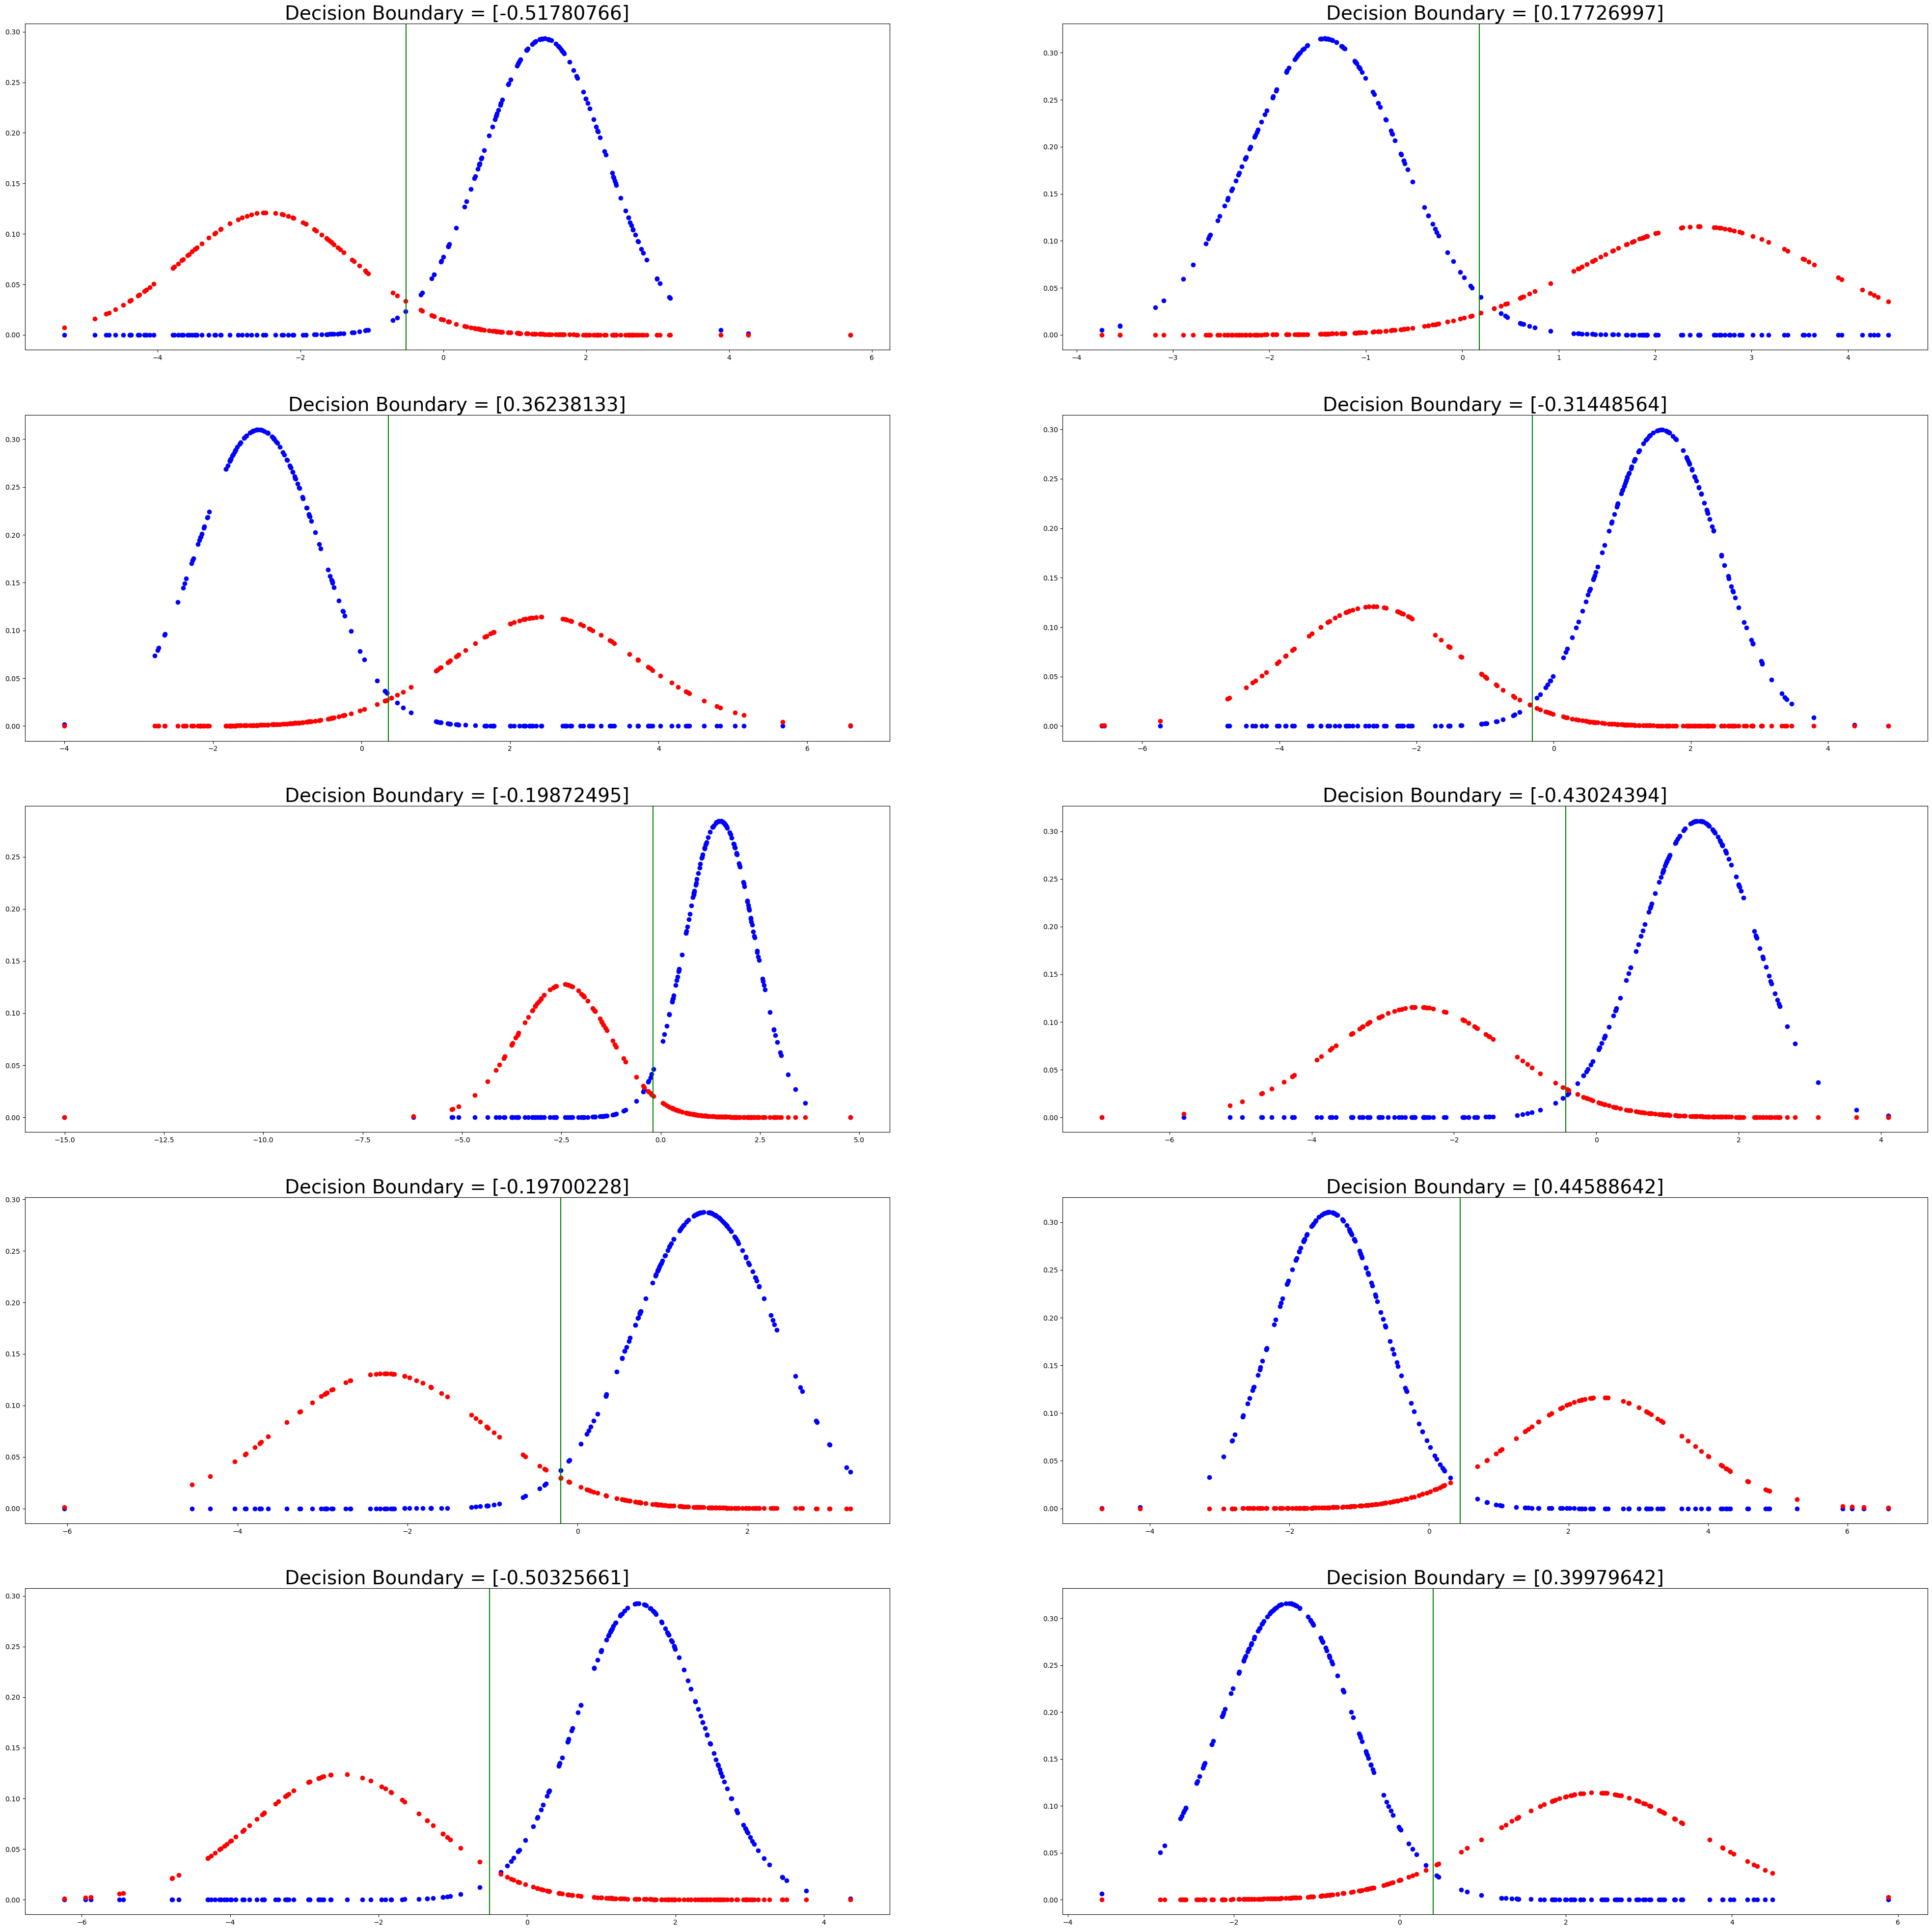

In [13]:
fig, axes  = plt.subplots(nrows=5,ncols=2,figsize=(50,50))

y0 = np.array(y0)
y1 = np.array(y1)
x = np.array(x)

for i in range(5):
    for j in range(2):
        k = (2*i)+j
        axes[i][j].scatter(x[k],y0[k], color='blue')
        axes[i][j].scatter(x[k],y1[k], color='red')
        axes[i][j].axvline(x=db[k], color='green')
        title = str("Decision Boundary = {}".format(db[k]))
        axes[i][j].set_title(title, fontsize = 28)

In [14]:
def computeMetrics(y_actual, y_predicted):
    tp = np.sum((y_actual == 1) & (y_predicted == 1))
    tn = np.sum((y_actual == 0) & (y_predicted == 0))
    fp = np.sum((y_actual == 0) & (y_predicted == 1))        
    fn = np.sum((y_actual == 1) & (y_predicted == 0)) 
    accuracy = 100*(np.sum(y_actual == y_predicted)/len(y_actual))
    precision = tp/np.sum(tp+fp)
    recall = tp/np.sum(tp+fn)
    return accuracy, precision, recall

In [15]:
acc = [1]*10
prec = [1]*10
rec = [1]*10
for i in range(10):
    acc[i], prec[i], rec[i] = computeMetrics(y_test[i], yPred[i])
    print("Metrics for test-train split {}".format(i))
    print(acc[i], prec[i], rec[i])
    print("\n")

Metrics for test-train split 0
97.3404255319149 0.9857142857142858 0.9452054794520548


Metrics for test-train split 1
95.74468085106383 0.9444444444444444 0.9444444444444444


Metrics for test-train split 2
95.74468085106383 0.971830985915493 0.92


Metrics for test-train split 3
95.2127659574468 0.9692307692307692 0.9


Metrics for test-train split 4
96.27659574468085 0.9692307692307692 0.9264705882352942


Metrics for test-train split 5
95.2127659574468 0.9571428571428572 0.9178082191780822


Metrics for test-train split 6
96.80851063829788 0.9661016949152542 0.9344262295081968


Metrics for test-train split 7
96.27659574468085 1.0 0.9027777777777778


Metrics for test-train split 8
95.2127659574468 0.9838709677419355 0.8840579710144928


Metrics for test-train split 9
97.3404255319149 1.0 0.9315068493150684




In [16]:
acc = np.array(acc)
prec = np.array(prec)
rec = np.array(rec)

print("Mean Accuracy = {} and Variance of Accuracy = {}".format(np.mean(acc), np.var(acc)))
print("Mean Precision = {} and Variance of Precision = {}".format(np.mean(prec), np.var(prec)))
print("Mean Recall = {} and Variance of Recall = {}".format(np.mean(rec), np.var(rec)))

Mean Accuracy = 96.11702127659575 and Variance of Accuracy = 0.6252829334540574
Mean Precision = 0.9747566774335809 and Variance of Precision = 0.0002851207985647865
Mean Recall = 0.9206697558925411 and Variance of Recall = 0.00036039918091811064
